In [7]:
!pip install imbalanced-learn

     ---------------------------------------- 0.0/235.6 kB ? eta -:--:--
     - -------------------------------------- 10.2/235.6 kB ? eta -:--:--
     ---------------------------- --------- 174.1/235.6 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 235.6/235.6 kB 2.4 MB/s eta 0:00:00


In [4]:
import imblearn
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from imblearn.over_sampling import SMOTE
from numpy import where
oversample = SMOTE()

### Import libraries

In [5]:
import glob
import librosa
import os
import sklearn.mixture
import sys
# import pysptk
import pyworld
import opensmile
import audiofile
#import audb

import time

import numpy as np
import pandas as pd

In [6]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

## Open Smile

In [7]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
#smile.feature_names
# setting up the feature extracter

In [8]:
smile.feature_names

['F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'spectralFlux_sma3_amean',
 'spectralFlux_sma3_stddevNorm',
 'mfcc1_sma3_amean',
 'mfcc1_sma3_stddevNorm',
 'mfcc2_sma3_amean',
 'mfcc2_sma3_stddevNorm',
 'mfcc3_sma3_amean',
 'mfcc3_sma3_stddevNorm',
 'mfcc4_

## Speaker wise performance

### Feature extraction

In [9]:
class DataPrep:
    def __init__(self, folderPath=None):




        self.folderPath = folderPath
        #         self.classFolder = os.listdir(self.folderPath)

        self.spk_folders_path = os.path.join(self.folderPath)
        self.spk_folders = os.listdir(self.spk_folders_path)
        self.files=[]

        #         print(self.classFolder)

        self.file_features = np.zeros((1,88))
#         self.labels = np.zeros(1)

        Y=[0]
        spk_label=['sp']
        for spks in range(len(self.spk_folders)):

            print(self.spk_folders[spks])

            self.spk_files_path = os.path.join(self.folderPath, self.spk_folders[spks])
            self.spk_files = os.listdir(self.spk_files_path)

            #                 print(self.spk_files)

            for spk_file in range(len(self.spk_files)):
                if(os.path.isdir(os.path.join(self.folderPath,self.spk_folders[spks],self.spk_files[spk_file]))):
                    continue
                wav_path = os.path.join(self.folderPath,self.spk_folders[spks],self.spk_files[spk_file])
#                 print(wav_path)

                self.files.append(self.spk_files[spk_file])
                print(self.spk_files[spk_file])
                y = smile.process_file(wav_path)

                ######################################################################

                #                     print(mfcc)

                file_feats = np.asarray(y)

                self.file_features = np.concatenate((self.file_features, file_feats),axis=0)
                label=self.spk_folders[spks]
                label=label[2]
#                 print(label)
                if label=='D':
                    l=0
                else:
                    l=1

#                 print(l)
                Y.append(l)
                if("Train" in self.folderPath):
                    spk_label.append(self.spk_folders[spks][0]+'_'+self.folderPath[15]+'_'+self.spk_files[spk_file])
                else:
                    spk_label.append(self.spk_folders[spks][0]+'_'+self.folderPath[14]+'_'+self.spk_files[spk_file])
#                 self.labels = np.concatenate((self.labels,np.ones((len(file_feats),1))*y),axis=0)
                #                 self.labels = np.concatenate((self.labels,np.ones((len(file_feats),1))*cls), axis=0)
#                 print(spk_label)
#                 print(self.folderPath,self.spk_folders[spks],self.spk_files[spk_file])

        self.file_features = self.file_features[1:,:]

        self.labels=np.asarray(Y)
        self.labels=self.labels.T
        self.labels=self.labels[1:]

        self.speaker_labels=np.asarray(spk_label)
        self.speaker_labels=self.speaker_labels.T
        self.speaker_labels=self.speaker_labels[1:]

In [10]:
def accuracy(y_test, prob_score, s_test):
    spk_list=list(set(s_test))
#     print(spk_list)
    avg_score=np.zeros((len(spk_list),2))

    for i in range(len(spk_list)):
        count=0
        for j in range(len(s_test)):
            if (spk_list[i] == s_test[j]):
                avg_score[i,0]=avg_score[i,0]+prob_score[j,0]
                avg_score[i,1]=avg_score[i,1]+prob_score[j,1]
                count=count+1
        avg_score[i]=avg_score[i]/(count)

    y_final=[10]
    for i in range(len(spk_list)):
        if (avg_score[i,0]>=avg_score[i,1]):
            y_final.append(0)
        else:
            y_final.append(1)
    y_final=y_final[1:]
    y_test=[10]
    for i in range(len(spk_list)):
        label=spk_list[i][2]
        if label=='D':
            y_test.append(0)
        else:
            y_test.append(1)
    y_test=y_test[1:]

    print("Speaker level accuracy: ",accuracy_score(y_test, y_final))
    print(sklearn.metrics.confusion_matrix(y_test, y_final))


## Loading data into csv

In [11]:
Train_dataD=DataPrep("DAIC-WOZ/Train/Depression")
Train_dataN=DataPrep("DAIC-WOZ/Train/NonDepression")

Test_dataD=DataPrep("DAIC-WOZ/Test/Depression")
Test_dataN=DataPrep("DAIC-WOZ/Test/NonDepression")

Female
319_108.wav
319_110.wav
319_113.wav
319_117.wav
319_118.wav
319_129.wav
319_130.wav
319_133.wav
319_141.wav
319_145.wav
319_146.wav
319_151.wav
319_152.wav
319_153.wav
319_154.wav
319_155.wav
319_16.wav
319_160.wav
319_165.wav
319_169.wav
319_17.wav
319_173.wav
319_174.wav
319_177.wav
319_178.wav
319_181.wav
319_20.wav
319_23.wav
319_28.wav
319_30.wav
319_33.wav
319_40.wav
319_44.wav
319_49.wav
319_51.wav
319_52.wav
319_59.wav
319_61.wav
319_62.wav
319_65.wav
319_68.wav
319_71.wav
319_72.wav
319_80.wav
319_92.wav
319_97.wav
320_102.wav
320_105.wav
320_106.wav
320_123.wav
320_131.wav
320_135.wav
320_141.wav
320_151.wav
320_158.wav
320_168.wav
320_184.wav
320_190.wav
320_201.wav
320_208.wav
320_244.wav
320_246.wav
320_252.wav
320_47.wav
320_62.wav
320_66.wav
320_70.wav
320_74.wav
320_75.wav
320_83.wav
321_100.wav
321_113.wav
321_117.wav
321_124.wav
321_132.wav
321_133.wav
321_142.wav
321_175.wav
321_176.wav
321_184.wav
321_189.wav
321_202.wav
321_203.wav
321_21.wav
321_24.wav
321_

372_169.wav
372_171.wav
372_172.wav
372_173.wav
372_174.wav
372_175.wav
372_177.wav
372_179.wav
372_18.wav
372_180.wav
372_186.wav
372_187.wav
372_190.wav
372_192.wav
372_193.wav
372_194.wav
372_195.wav
372_196.wav
372_198.wav
372_200.wav
372_201.wav
372_203.wav
372_206.wav
372_207.wav
372_208.wav
372_21.wav
372_210.wav
372_211.wav
372_212.wav
372_213.wav
372_215.wav
372_222.wav
372_229.wav
372_230.wav
372_231.wav
372_232.wav
372_234.wav
372_235.wav
372_238.wav
372_246.wav
372_249.wav
372_252.wav
372_253.wav
372_257.wav
372_259.wav
372_261.wav
372_265.wav
372_266.wav
372_268.wav
372_269.wav
372_270.wav
372_272.wav
372_277.wav
372_280.wav
372_281.wav
372_283.wav
372_287.wav
372_290.wav
372_291.wav
372_293.wav
372_294.wav
372_297.wav
372_301.wav
372_306.wav
372_310.wav
372_313.wav
372_314.wav
372_315.wav
372_318.wav
372_319.wav
372_325.wav
372_327.wav
372_328.wav
372_33.wav
372_330.wav
372_335.wav
372_34.wav
372_341.wav
372_342.wav
372_343.wav
372_344.wav
372_347.wav
372_348.wav
372_349.

356_169.wav
356_174.wav
356_175.wav
356_176.wav
356_177.wav
356_178.wav
356_18.wav
356_183.wav
356_184.wav
356_185.wav
356_188.wav
356_189.wav
356_193.wav
356_194.wav
356_195.wav
356_197.wav
356_199.wav
356_200.wav
356_203.wav
356_204.wav
356_208.wav
356_209.wav
356_210.wav
356_212.wav
356_216.wav
356_217.wav
356_218.wav
356_219.wav
356_22.wav
356_220.wav
356_221.wav
356_222.wav
356_228.wav
356_229.wav
356_232.wav
356_233.wav
356_239.wav
356_240.wav
356_25.wav
356_37.wav
356_40.wav
356_43.wav
356_44.wav
356_49.wav
356_56.wav
356_59.wav
356_60.wav
356_62.wav
356_64.wav
356_68.wav
356_70.wav
356_71.wav
356_72.wav
356_73.wav
356_78.wav
356_80.wav
356_81.wav
356_85.wav
356_96.wav
356_97.wav
356_99.wav
380_103.wav
380_104.wav
380_105.wav
380_111.wav
380_113.wav
380_114.wav
380_118.wav
380_119.wav
380_120.wav
380_122.wav
380_125.wav
380_129.wav
380_133.wav
380_134.wav
380_136.wav
380_137.wav
380_138.wav
380_140.wav
380_141.wav
380_142.wav
380_145.wav
380_147.wav
380_149.wav
380_154.wav
380_1

315_163.wav
315_164.wav
315_165.wav
315_168.wav
315_171.wav
317_68.wav
317_71.wav
317_74.wav
317_76.wav
317_80.wav
317_83.wav
322_101.wav
322_103.wav
322_105.wav
322_171.wav
322_174.wav
322_175.wav
322_177.wav
322_182.wav
322_184.wav
322_95.wav
322_96.wav
322_99.wav
327_66.wav
327_75.wav
327_78.wav
327_83.wav
327_86.wav
327_93.wav
341_242.wav
341_245.wav
341_247.wav
341_259.wav
360_16.wav
360_20.wav
369_128.wav
369_129.wav
369_130.wav
369_135.wav
369_136.wav
369_137.wav
369_138.wav
369_47.wav
369_51.wav
369_52.wav
369_54.wav
369_59.wav
369_60.wav
374_121.wav
374_128.wav
374_129.wav
374_130.wav
392_35.wav
392_41.wav
392_45.wav
392_47.wav
Female
303_10.wav
303_103.wav
303_11.wav
303_110.wav
303_111.wav
303_112.wav
303_113.wav
303_114.wav
303_117.wav
303_122.wav
303_126.wav
303_128.wav
303_131.wav
303_134.wav
303_135.wav
303_141.wav
303_142.wav
303_145.wav
303_148.wav
303_15.wav
303_150.wav
303_155.wav
303_164.wav
303_167.wav
303_169.wav
303_171.wav
303_173.wav
303_179.wav
303_18.wav
303_

419_153.wav
419_154.wav
419_155.wav
419_156.wav
419_157.wav
419_159.wav
419_161.wav
419_169.wav
419_17.wav
419_170.wav
419_171.wav
419_172.wav
419_174.wav
419_178.wav
419_181.wav
419_185.wav
419_187.wav
419_189.wav
419_19.wav
419_199.wav
419_200.wav
419_201.wav
419_202.wav
419_210.wav
419_211.wav
419_22.wav
419_220.wav
419_221.wav
419_223.wav
419_226.wav
419_227.wav
419_228.wav
419_23.wav
419_230.wav
419_232.wav
419_235.wav
419_238.wav
419_240.wav
419_26.wav
419_29.wav
419_32.wav
419_36.wav
419_40.wav
419_43.wav
419_44.wav
419_45.wav
419_48.wav
419_50.wav
419_52.wav
419_53.wav
419_54.wav
419_61.wav
419_62.wav
419_65.wav
419_67.wav
419_70.wav
419_76.wav
419_79.wav
419_83.wav
419_84.wav
419_85.wav
419_86.wav
419_9.wav
419_90.wav
419_92.wav
419_94.wav
419_95.wav
419_96.wav
423_100.wav
423_101.wav
423_102.wav
423_105.wav
423_108.wav
423_111.wav
423_114.wav
423_116.wav
423_118.wav
423_119.wav
423_121.wav
423_123.wav
423_124.wav
423_129.wav
423_131.wav
423_132.wav
423_135.wav
423_139.wav
423

449_216.wav
449_23.wav
449_24.wav
449_27.wav
449_29.wav
449_30.wav
449_31.wav
449_32.wav
449_38.wav
449_39.wav
449_40.wav
449_44.wav
449_45.wav
449_49.wav
449_50.wav
449_51.wav
449_52.wav
449_59.wav
449_60.wav
449_61.wav
449_62.wav
449_65.wav
449_66.wav
449_67.wav
449_68.wav
449_69.wav
449_71.wav
449_72.wav
449_73.wav
449_75.wav
449_76.wav
449_77.wav
449_81.wav
449_82.wav
449_83.wav
449_84.wav
449_86.wav
449_87.wav
449_89.wav
449_90.wav
449_91.wav
449_94.wav
449_95.wav
449_96.wav
449_98.wav
449_99.wav
454_100.wav
454_112.wav
454_118.wav
454_121.wav
454_128.wav
454_129.wav
454_133.wav
454_136.wav
454_137.wav
454_139.wav
454_140.wav
454_154.wav
454_167.wav
454_189.wav
454_19.wav
454_195.wav
454_200.wav
454_201.wav
454_208.wav
454_211.wav
454_214.wav
454_26.wav
454_39.wav
454_61.wav
454_64.wav
454_67.wav
454_72.wav
454_78.wav
454_79.wav
454_81.wav
454_84.wav
454_85.wav
454_90.wav
454_91.wav
454_97.wav
455_100.wav
455_101.wav
455_102.wav
455_103.wav
455_110.wav
455_113.wav
455_116.wav
455_

305_298.wav
305_300.wav
305_301.wav
305_303.wav
305_304.wav
305_305.wav
305_308.wav
305_309.wav
305_31.wav
305_311.wav
305_312.wav
305_314.wav
305_316.wav
305_317.wav
305_321.wav
305_324.wav
305_327.wav
305_329.wav
305_330.wav
305_331.wav
305_335.wav
305_341.wav
305_342.wav
305_344.wav
305_347.wav
305_348.wav
305_349.wav
305_356.wav
305_357.wav
305_359.wav
305_360.wav
305_365.wav
305_368.wav
305_371.wav
305_372.wav
305_374.wav
305_378.wav
305_380.wav
305_384.wav
305_387.wav
305_388.wav
305_389.wav
305_392.wav
305_394.wav
305_397.wav
305_41.wav
305_43.wav
305_46.wav
305_49.wav
305_54.wav
305_58.wav
305_66.wav
305_67.wav
305_74.wav
305_76.wav
305_78.wav
305_79.wav
305_81.wav
305_83.wav
305_84.wav
305_91.wav
305_92.wav
305_96.wav
305_97.wav
305_98.wav
310_101.wav
310_104.wav
310_105.wav
310_110.wav
310_117.wav
310_123.wav
310_124.wav
310_129.wav
310_130.wav
310_149.wav
310_151.wav
310_162.wav
310_169.wav
310_174.wav
310_179.wav
310_189.wav
310_195.wav
310_197.wav
310_199.wav
310_201.wav
3

340_19.wav
340_22.wav
340_39.wav
340_42.wav
340_46.wav
340_50.wav
340_51.wav
340_56.wav
340_72.wav
340_74.wav
340_76.wav
340_83.wav
340_85.wav
340_89.wav
340_96.wav
340_99.wav
343_100.wav
343_105.wav
343_113.wav
343_114.wav
343_118.wav
343_123.wav
343_126.wav
343_127.wav
343_137.wav
343_141.wav
343_143.wav
343_146.wav
343_147.wav
343_161.wav
343_164.wav
343_180.wav
343_188.wav
343_19.wav
343_190.wav
343_212.wav
343_215.wav
343_223.wav
343_225.wav
343_230.wav
343_231.wav
343_32.wav
343_39.wav
343_40.wav
343_41.wav
343_42.wav
343_49.wav
343_53.wav
343_54.wav
343_59.wav
343_62.wav
343_72.wav
343_73.wav
343_75.wav
343_80.wav
343_83.wav
343_87.wav
343_88.wav
343_93.wav
343_94.wav
357_105.wav
357_117.wav
357_119.wav
357_15.wav
357_20.wav
357_25.wav
357_32.wav
357_40.wav
357_42.wav
357_50.wav
357_54.wav
357_55.wav
357_61.wav
357_71.wav
357_73.wav
357_78.wav
357_80.wav
357_89.wav
357_9.wav
357_99.wav
358_118.wav
358_12.wav
358_120.wav
358_122.wav
358_123.wav
358_125.wav
358_127.wav
358_129.wav

368_282.wav
368_283.wav
368_284.wav
368_285.wav
368_286.wav
368_287.wav
368_29.wav
368_290.wav
368_291.wav
368_292.wav
368_295.wav
368_297.wav
368_299.wav
368_301.wav
368_302.wav
368_304.wav
368_308.wav
368_32.wav
368_33.wav
368_34.wav
368_36.wav
368_38.wav
368_39.wav
368_42.wav
368_43.wav
368_45.wav
368_46.wav
368_48.wav
368_50.wav
368_51.wav
368_57.wav
368_58.wav
368_59.wav
368_60.wav
368_61.wav
368_67.wav
368_68.wav
368_73.wav
368_76.wav
368_77.wav
368_78.wav
368_79.wav
368_84.wav
368_85.wav
368_86.wav
368_87.wav
368_88.wav
368_94.wav
368_96.wav
370_10.wav
370_102.wav
370_105.wav
370_106.wav
370_107.wav
370_108.wav
370_110.wav
370_112.wav
370_113.wav
370_116.wav
370_117.wav
370_118.wav
370_120.wav
370_121.wav
370_128.wav
370_129.wav
370_130.wav
370_131.wav
370_132.wav
370_133.wav
370_137.wav
370_138.wav
370_139.wav
370_14.wav
370_140.wav
370_141.wav
370_143.wav
370_144.wav
370_145.wav
370_15.wav
370_151.wav
370_152.wav
370_153.wav
370_154.wav
370_155.wav
370_157.wav
370_158.wav
370_

400_179.wav
400_182.wav
400_185.wav
400_186.wav
400_187.wav
400_188.wav
400_189.wav
400_19.wav
400_195.wav
400_197.wav
400_206.wav
400_210.wav
400_211.wav
400_212.wav
400_216.wav
400_221.wav
400_223.wav
400_227.wav
400_24.wav
400_28.wav
400_30.wav
400_31.wav
400_34.wav
400_38.wav
400_40.wav
400_42.wav
400_48.wav
400_52.wav
400_55.wav
400_56.wav
400_60.wav
400_63.wav
400_65.wav
400_68.wav
400_71.wav
400_73.wav
400_75.wav
400_79.wav
400_80.wav
400_81.wav
400_86.wav
400_89.wav
400_90.wav
400_94.wav
400_97.wav
400_99.wav
409_102.wav
409_103.wav
409_104.wav
409_105.wav
409_106.wav
409_112.wav
409_113.wav
409_114.wav
409_115.wav
409_120.wav
409_123.wav
409_124.wav
409_126.wav
409_127.wav
409_128.wav
409_129.wav
409_130.wav
409_131.wav
409_138.wav
409_143.wav
409_145.wav
409_146.wav
409_149.wav
409_150.wav
409_152.wav
409_153.wav
409_154.wav
409_155.wav
409_158.wav
409_161.wav
409_163.wav
409_166.wav
409_17.wav
409_171.wav
409_172.wav
409_173.wav
409_176.wav
409_181.wav
409_182.wav
409_186.wa

445_150.wav
445_155.wav
445_157.wav
445_160.wav
445_166.wav
445_167.wav
445_169.wav
445_170.wav
445_172.wav
445_24.wav
445_26.wav
445_27.wav
445_33.wav
445_38.wav
445_42.wav
445_43.wav
445_50.wav
445_56.wav
445_57.wav
445_60.wav
445_61.wav
445_64.wav
445_68.wav
445_69.wav
445_70.wav
445_75.wav
445_76.wav
445_77.wav
445_80.wav
445_83.wav
445_84.wav
445_85.wav
445_86.wav
445_9.wav
445_92.wav
445_93.wav
445_95.wav
445_96.wav
445_97.wav
447_10.wav
447_100.wav
447_102.wav
447_104.wav
447_106.wav
447_107.wav
447_108.wav
447_109.wav
447_110.wav
447_111.wav
447_113.wav
447_114.wav
447_118.wav
447_119.wav
447_120.wav
447_123.wav
447_131.wav
447_132.wav
447_137.wav
447_138.wav
447_14.wav
447_142.wav
447_143.wav
447_149.wav
447_15.wav
447_152.wav
447_154.wav
447_155.wav
447_159.wav
447_160.wav
447_163.wav
447_164.wav
447_165.wav
447_167.wav
447_168.wav
447_17.wav
447_170.wav
447_176.wav
447_18.wav
447_182.wav
447_188.wav
447_189.wav
447_22.wav
447_27.wav
447_29.wav
447_30.wav
447_32.wav
447_33.wa

475_86.wav
475_87.wav
475_88.wav
475_9.wav
475_91.wav
475_93.wav
475_94.wav
475_95.wav
479_100.wav
479_104.wav
479_115.wav
479_116.wav
479_136.wav
479_137.wav
479_138.wav
479_141.wav
479_153.wav
479_170.wav
479_182.wav
479_187.wav
479_194.wav
479_199.wav
479_201.wav
479_206.wav
479_207.wav
479_211.wav
479_214.wav
479_217.wav
479_220.wav
479_225.wav
479_227.wav
479_229.wav
479_230.wav
479_232.wav
479_237.wav
479_32.wav
479_38.wav
479_45.wav
479_47.wav
479_48.wav
479_54.wav
479_55.wav
479_60.wav
479_67.wav
479_71.wav
479_82.wav
479_83.wav
479_84.wav
479_87.wav
479_91.wav
485_100.wav
485_104.wav
485_105.wav
485_108.wav
485_111.wav
485_114.wav
485_115.wav
485_120.wav
485_123.wav
485_129.wav
485_130.wav
485_132.wav
485_134.wav
485_142.wav
485_145.wav
485_148.wav
485_15.wav
485_152.wav
485_154.wav
485_158.wav
485_162.wav
485_17.wav
485_20.wav
485_21.wav
485_23.wav
485_27.wav
485_31.wav
485_33.wav
485_38.wav
485_39.wav
485_43.wav
485_45.wav
485_48.wav
485_53.wav
485_54.wav
485_58.wav
485_6.wa

410_92.wav
410_97.wav
410_98.wav
421_106.wav
421_108.wav
421_111.wav
421_115.wav
421_117.wav
421_120.wav
421_122.wav
421_123.wav
421_134.wav
421_14.wav
421_140.wav
421_149.wav
421_155.wav
421_159.wav
421_16.wav
421_160.wav
421_162.wav
421_165.wav
421_166.wav
421_167.wav
421_168.wav
421_172.wav
421_175.wav
421_176.wav
421_177.wav
421_181.wav
421_183.wav
421_187.wav
421_189.wav
421_192.wav
421_198.wav
421_201.wav
421_202.wav
421_205.wav
421_209.wav
421_211.wav
421_216.wav
421_217.wav
421_23.wav
421_26.wav
421_27.wav
421_30.wav
421_33.wav
421_36.wav
421_37.wav
421_39.wav
421_47.wav
421_48.wav
421_52.wav
421_54.wav
421_55.wav
421_58.wav
421_59.wav
421_62.wav
421_63.wav
421_66.wav
421_67.wav
421_71.wav
421_76.wav
421_78.wav
421_82.wav
421_86.wav
421_90.wav
421_93.wav
421_94.wav
Male
309_103.wav
309_106.wav
309_109.wav
309_110.wav
309_116.wav
309_122.wav
309_133.wav
309_134.wav
309_150.wav
309_159.wav
309_166.wav
309_18.wav
309_24.wav
309_39.wav
309_44.wav
309_47.wav
309_71.wav
309_75.wav
30

314_303.wav
314_304.wav
314_306.wav
314_31.wav
314_311.wav
314_312.wav
314_316.wav
314_318.wav
314_319.wav
314_320.wav
314_321.wav
314_322.wav
314_323.wav
314_324.wav
314_333.wav
314_337.wav
314_338.wav
314_339.wav
314_34.wav
314_341.wav
314_342.wav
314_343.wav
314_344.wav
314_349.wav
314_350.wav
314_352.wav
314_354.wav
314_355.wav
314_359.wav
314_360.wav
314_361.wav
314_369.wav
314_371.wav
314_372.wav
314_373.wav
314_375.wav
314_376.wav
314_379.wav
314_38.wav
314_384.wav
314_390.wav
314_396.wav
314_398.wav
314_403.wav
314_408.wav
314_409.wav
314_412.wav
314_413.wav
314_414.wav
314_415.wav
314_418.wav
314_419.wav
314_424.wav
314_426.wav
314_430.wav
314_431.wav
314_433.wav
314_434.wav
314_435.wav
314_436.wav
314_438.wav
314_440.wav
314_444.wav
314_445.wav
314_449.wav
314_45.wav
314_456.wav
314_458.wav
314_460.wav
314_461.wav
314_462.wav
314_463.wav
314_464.wav
314_55.wav
314_57.wav
314_58.wav
314_59.wav
314_63.wav
314_64.wav
314_67.wav
314_72.wav
314_77.wav
314_79.wav
314_80.wav
314_81.

431_51.wav
431_52.wav
431_59.wav
431_60.wav
431_86.wav
431_89.wav
431_95.wav
435_109.wav
435_116.wav
435_117.wav
435_118.wav
435_119.wav
435_12.wav
435_120.wav
435_122.wav
435_128.wav
435_133.wav
435_135.wav
435_136.wav
435_138.wav
435_141.wav
435_146.wav
435_148.wav
435_149.wav
435_150.wav
435_151.wav
435_152.wav
435_157.wav
435_158.wav
435_16.wav
435_164.wav
435_166.wav
435_174.wav
435_188.wav
435_189.wav
435_190.wav
435_193.wav
435_194.wav
435_195.wav
435_196.wav
435_198.wav
435_203.wav
435_214.wav
435_215.wav
435_217.wav
435_221.wav
435_237.wav
435_244.wav
435_246.wav
435_248.wav
435_260.wav
435_263.wav
435_267.wav
435_276.wav
435_279.wav
435_280.wav
435_282.wav
435_285.wav
435_35.wav
435_46.wav
435_47.wav
435_48.wav
435_56.wav
435_57.wav
435_61.wav
435_64.wav
435_72.wav
435_73.wav
435_80.wav
435_82.wav
435_91.wav
435_92.wav
438_100.wav
438_103.wav
438_104.wav
438_106.wav
438_107.wav
438_108.wav
438_109.wav
438_110.wav
438_114.wav
438_116.wav
438_118.wav
438_119.wav
438_120.wav
438

469_23.wav
469_239.wav
469_240.wav
469_241.wav
469_242.wav
469_243.wav
469_248.wav
469_25.wav
469_251.wav
469_254.wav
469_255.wav
469_256.wav
469_257.wav
469_26.wav
469_27.wav
469_32.wav
469_33.wav
469_36.wav
469_38.wav
469_49.wav
469_52.wav
469_55.wav
469_57.wav
469_58.wav
469_59.wav
469_62.wav
469_64.wav
469_67.wav
469_68.wav
469_71.wav
469_72.wav
469_73.wav
469_79.wav
469_80.wav
469_81.wav
469_85.wav
469_86.wav
469_90.wav
469_91.wav
469_93.wav
469_94.wav
469_98.wav
470_102.wav
470_107.wav
470_109.wav
470_114.wav
470_119.wav
470_12.wav
470_121.wav
470_122.wav
470_123.wav
470_130.wav
470_132.wav
470_134.wav
470_142.wav
470_144.wav
470_146.wav
470_147.wav
470_148.wav
470_153.wav
470_161.wav
470_169.wav
470_17.wav
470_170.wav
470_172.wav
470_175.wav
470_176.wav
470_18.wav
470_180.wav
470_182.wav
470_184.wav
470_190.wav
470_197.wav
470_198.wav
470_199.wav
470_205.wav
470_206.wav
470_208.wav
470_212.wav
470_213.wav
470_216.wav
470_217.wav
470_219.wav
470_225.wav
470_231.wav
470_233.wav
47

407_179.wav
407_180.wav
407_181.wav
407_182.wav
407_186.wav
407_187.wav
407_188.wav
407_189.wav
407_196.wav
407_198.wav
407_200.wav
407_201.wav
407_203.wav
407_204.wav
407_205.wav
407_206.wav
407_207.wav
407_208.wav
407_21.wav
407_211.wav
407_212.wav
407_213.wav
407_214.wav
407_215.wav
407_216.wav
407_22.wav
407_225.wav
407_228.wav
407_23.wav
407_230.wav
407_231.wav
407_232.wav
407_233.wav
407_237.wav
407_238.wav
407_24.wav
407_240.wav
407_242.wav
407_244.wav
407_252.wav
407_253.wav
407_254.wav
407_259.wav
407_260.wav
407_261.wav
407_262.wav
407_264.wav
407_265.wav
407_270.wav
407_271.wav
407_275.wav
407_276.wav
407_277.wav
407_278.wav
407_279.wav
407_28.wav
407_287.wav
407_289.wav
407_291.wav
407_292.wav
407_293.wav
407_294.wav
407_295.wav
407_296.wav
407_297.wav
407_298.wav
407_30.wav
407_306.wav
407_307.wav
407_308.wav
407_313.wav
407_316.wav
407_32.wav
407_324.wav
407_328.wav
407_330.wav
407_331.wav
407_332.wav
407_334.wav
407_335.wav
407_336.wav
407_338.wav
407_339.wav
407_341.wav

481_41.wav
481_42.wav
481_43.wav
481_44.wav
481_49.wav
481_50.wav
481_53.wav
481_57.wav
481_58.wav
481_59.wav
481_62.wav
481_63.wav
481_66.wav
481_67.wav
481_70.wav
481_82.wav
481_83.wav
481_84.wav
481_91.wav
481_92.wav
481_93.wav
481_94.wav
481_95.wav


# Loading Data from Csv

In [188]:
type(Test_dataD)

__main__.DataPrep

In [12]:
X_trainD=Train_dataD.file_features
# Y_trainD=Train_dataD.labels
S_trainD=Train_dataD.speaker_labels

X_trainN=Train_dataN.file_features
# Y_trainN=Train_dataN.labels
S_trainN=Train_dataN.speaker_labels

X_testD=Test_dataD.file_features
# Y_testD=Test_dataD.labels
S_testD=Test_dataD.speaker_labels

X_testN=Test_dataN.file_features
# Y_testN=Test_dataN.labels
S_testN=Test_dataN.speaker_labels

In [13]:

X_train_full=np.concatenate((X_trainD, X_trainN),axis=0)
# y_train_full=np.concatenate((Y_trainD, Y_trainN),axis=0)
s_train_full=np.concatenate((S_trainD, S_trainN),axis=0)


X_test_full=np.concatenate((X_testD, X_testN),axis=0)
# y_test_full=np.concatenate((Y_testD, Y_testN),axis=0)
s_test_full=np.concatenate((S_testD, S_testN),axis=0)
np.shape(X_test_full)
# np.shape(y_test_full)
np.shape(s_test_full)



(4135,)

In [33]:
y_traini_D=Train_dataD.labels
y_traini_N=Train_dataN.labels
y_testi_D=Test_dataD.labels
y_testi_N=Test_dataN.labels
y_traini=np.concatenate((y_traini_D,y_traini_N))
y_testi=np.concatenate((y_testi_D,y_testi_N))
y_traini_D

array([1, 1, 1, ..., 1, 1, 1])

In [39]:
y_train_nog = np.zeros_like(s_train_full)
for i in range(len(s_train_full)):
    if 'F_D' in s_train_full[i] or 'M_D' in s_train_full[i]:
        y_train_nog[i] = '1'
    else:
        y_train_nog[i] = '0'
y_train_nog.shape

(7864,)

In [40]:
y_test_nog = np.zeros_like(s_test_full)
for i in range(len(s_test_full)):
    if 'F_D' in s_test_full[i] or 'M_D' in s_test_full[i]:
        y_test_nog[i] = '1'
    else:
        y_test_nog[i] = '0'
y_test_nog.shape

(4135,)

In [27]:
t1=np.array(Train_dataD.files)
t2=np.array(Train_dataN.files)
Train_file=np.concatenate((t1,t2))
te1=np.array(Test_dataD.files)
te2=np.array(Test_dataN.files)
Test_file=np.concatenate((te1,te2))

In [41]:
train_arr=np.concatenate((Train_file.reshape(-1, 1),X_train_full,y_train_nog.reshape(-1, 1)),axis=1)
test_arr=np.concatenate((Test_file.reshape(-1, 1),X_test_full,y_test_nog.reshape(-1, 1)),axis=1)
test_arr.shape

(4135, 90)

In [42]:
train_pd=pd.DataFrame(train_arr,columns=['File_name','F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'spectralFlux_sma3_amean',
 'spectralFlux_sma3_stddevNorm',
 'mfcc1_sma3_amean',
 'mfcc1_sma3_stddevNorm',
 'mfcc2_sma3_amean',
 'mfcc2_sma3_stddevNorm',
 'mfcc3_sma3_amean',
 'mfcc3_sma3_stddevNorm',
 'mfcc4_sma3_amean',
 'mfcc4_sma3_stddevNorm',
 'jitterLocal_sma3nz_amean',
 'jitterLocal_sma3nz_stddevNorm',
 'shimmerLocaldB_sma3nz_amean',
 'shimmerLocaldB_sma3nz_stddevNorm',
 'HNRdBACF_sma3nz_amean',
 'HNRdBACF_sma3nz_stddevNorm',
 'logRelF0-H1-H2_sma3nz_amean',
 'logRelF0-H1-H2_sma3nz_stddevNorm',
 'logRelF0-H1-A3_sma3nz_amean',
 'logRelF0-H1-A3_sma3nz_stddevNorm',
 'F1frequency_sma3nz_amean',
 'F1frequency_sma3nz_stddevNorm',
 'F1bandwidth_sma3nz_amean',
 'F1bandwidth_sma3nz_stddevNorm',
 'F1amplitudeLogRelF0_sma3nz_amean',
 'F1amplitudeLogRelF0_sma3nz_stddevNorm',
 'F2frequency_sma3nz_amean',
 'F2frequency_sma3nz_stddevNorm',
 'F2bandwidth_sma3nz_amean',
 'F2bandwidth_sma3nz_stddevNorm',
 'F2amplitudeLogRelF0_sma3nz_amean',
 'F2amplitudeLogRelF0_sma3nz_stddevNorm',
 'F3frequency_sma3nz_amean',
 'F3frequency_sma3nz_stddevNorm',
 'F3bandwidth_sma3nz_amean',
 'F3bandwidth_sma3nz_stddevNorm',
 'F3amplitudeLogRelF0_sma3nz_amean',
 'F3amplitudeLogRelF0_sma3nz_stddevNorm',
 'alphaRatioV_sma3nz_amean',
 'alphaRatioV_sma3nz_stddevNorm',
 'hammarbergIndexV_sma3nz_amean',
 'hammarbergIndexV_sma3nz_stddevNorm',
 'slopeV0-500_sma3nz_amean',
 'slopeV0-500_sma3nz_stddevNorm',
 'slopeV500-1500_sma3nz_amean',
 'slopeV500-1500_sma3nz_stddevNorm',
 'spectralFluxV_sma3nz_amean',
 'spectralFluxV_sma3nz_stddevNorm',
 'mfcc1V_sma3nz_amean',
 'mfcc1V_sma3nz_stddevNorm',
 'mfcc2V_sma3nz_amean',
 'mfcc2V_sma3nz_stddevNorm',
 'mfcc3V_sma3nz_amean',
 'mfcc3V_sma3nz_stddevNorm',
 'mfcc4V_sma3nz_amean',
 'mfcc4V_sma3nz_stddevNorm',
 'alphaRatioUV_sma3nz_amean',
 'hammarbergIndexUV_sma3nz_amean',
 'slopeUV0-500_sma3nz_amean',
 'slopeUV500-1500_sma3nz_amean',
 'spectralFluxUV_sma3nz_amean',
 'loudnessPeaksPerSec',
 'VoicedSegmentsPerSec',
 'MeanVoicedSegmentLengthSec',
 'StddevVoicedSegmentLengthSec',
 'MeanUnvoicedSegmentLength',
 'StddevUnvoicedSegmentLength',
 'equivalentSoundLevel_dBp','Label'])

In [43]:
test_pd=pd.DataFrame(test_arr,columns=['File_name','F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'spectralFlux_sma3_amean',
 'spectralFlux_sma3_stddevNorm',
 'mfcc1_sma3_amean',
 'mfcc1_sma3_stddevNorm',
 'mfcc2_sma3_amean',
 'mfcc2_sma3_stddevNorm',
 'mfcc3_sma3_amean',
 'mfcc3_sma3_stddevNorm',
 'mfcc4_sma3_amean',
 'mfcc4_sma3_stddevNorm',
 'jitterLocal_sma3nz_amean',
 'jitterLocal_sma3nz_stddevNorm',
 'shimmerLocaldB_sma3nz_amean',
 'shimmerLocaldB_sma3nz_stddevNorm',
 'HNRdBACF_sma3nz_amean',
 'HNRdBACF_sma3nz_stddevNorm',
 'logRelF0-H1-H2_sma3nz_amean',
 'logRelF0-H1-H2_sma3nz_stddevNorm',
 'logRelF0-H1-A3_sma3nz_amean',
 'logRelF0-H1-A3_sma3nz_stddevNorm',
 'F1frequency_sma3nz_amean',
 'F1frequency_sma3nz_stddevNorm',
 'F1bandwidth_sma3nz_amean',
 'F1bandwidth_sma3nz_stddevNorm',
 'F1amplitudeLogRelF0_sma3nz_amean',
 'F1amplitudeLogRelF0_sma3nz_stddevNorm',
 'F2frequency_sma3nz_amean',
 'F2frequency_sma3nz_stddevNorm',
 'F2bandwidth_sma3nz_amean',
 'F2bandwidth_sma3nz_stddevNorm',
 'F2amplitudeLogRelF0_sma3nz_amean',
 'F2amplitudeLogRelF0_sma3nz_stddevNorm',
 'F3frequency_sma3nz_amean',
 'F3frequency_sma3nz_stddevNorm',
 'F3bandwidth_sma3nz_amean',
 'F3bandwidth_sma3nz_stddevNorm',
 'F3amplitudeLogRelF0_sma3nz_amean',
 'F3amplitudeLogRelF0_sma3nz_stddevNorm',
 'alphaRatioV_sma3nz_amean',
 'alphaRatioV_sma3nz_stddevNorm',
 'hammarbergIndexV_sma3nz_amean',
 'hammarbergIndexV_sma3nz_stddevNorm',
 'slopeV0-500_sma3nz_amean',
 'slopeV0-500_sma3nz_stddevNorm',
 'slopeV500-1500_sma3nz_amean',
 'slopeV500-1500_sma3nz_stddevNorm',
 'spectralFluxV_sma3nz_amean',
 'spectralFluxV_sma3nz_stddevNorm',
 'mfcc1V_sma3nz_amean',
 'mfcc1V_sma3nz_stddevNorm',
 'mfcc2V_sma3nz_amean',
 'mfcc2V_sma3nz_stddevNorm',
 'mfcc3V_sma3nz_amean',
 'mfcc3V_sma3nz_stddevNorm',
 'mfcc4V_sma3nz_amean',
 'mfcc4V_sma3nz_stddevNorm',
 'alphaRatioUV_sma3nz_amean',
 'hammarbergIndexUV_sma3nz_amean',
 'slopeUV0-500_sma3nz_amean',
 'slopeUV500-1500_sma3nz_amean',
 'spectralFluxUV_sma3nz_amean',
 'loudnessPeaksPerSec',
 'VoicedSegmentsPerSec',
 'MeanVoicedSegmentLengthSec',
 'StddevVoicedSegmentLengthSec',
 'MeanUnvoicedSegmentLength',
 'StddevUnvoicedSegmentLength',
 'equivalentSoundLevel_dBp','Label'])

In [44]:
train_pd.to_csv('DAIC_WOZ_train.csv',index=False)
test_pd.to_csv('DAIC_WOZ_test.csv',index=False)

## Do not run everytime

In [14]:
X_train_full_df=pd.DataFrame(X_train_full)
s_train_full_df=pd.DataFrame(s_train_full)
X_test_full_df=pd.DataFrame(X_test_full)
s_test_full_df=pd.DataFrame(s_test_full)

In [15]:
# X_train_full_df.to_csv("Daic_X_train.csv")
# s_train_full_df.to_csv("Daic_y_train.csv")
# X_test_full_df.to_csv("Daic_X_test.csv")
# s_test_full_df.to_csv("Daic_y_test.csv")

## Till here

In [8]:
X_train_full_df=pd.read_csv("Daic_X_train.csv").drop(['Unnamed: 0'],axis=1)
s_train_full_df=pd.read_csv("Daic_y_train.csv").drop(['Unnamed: 0'],axis=1)
X_test_full_df=pd.read_csv("Daic_X_test.csv").drop(['Unnamed: 0'],axis=1)
s_test_full_df=pd.read_csv("Daic_y_test.csv").drop(['Unnamed: 0'],axis=1)

In [9]:
X_train_full_df

,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0,22.141134,0.082231,20.151621,22.279160,23.964336,3.812716,103.089966,119.216797,10.383823,11.669080,...,-0.023775,-0.000349,0.395821,4.225352,2.189781,0.303333,0.012472,0.130000,0.077889,-14.301528
1,23.670998,0.123909,21.412556,22.706928,26.246941,4.834385,95.873154,87.045502,11.828790,7.354484,...,-0.020282,0.002420,0.150770,3.548387,1.967213,0.363333,0.251705,0.125000,0.078687,-17.416756
2,23.425415,0.098913,21.303453,22.956043,24.994799,3.691345,66.809525,91.398422,27.506506,22.893307,...,-0.025628,0.001703,0.168380,3.846154,2.280130,0.235714,0.141104,0.182857,0.163595,-15.851289
3,19.425419,0.070607,18.239971,19.108694,20.066917,1.826946,67.299538,75.417847,9.802303,8.187330,...,-0.013369,-0.013527,0.267981,3.896104,3.097345,0.167143,0.105114,0.135714,0.091941,-18.937111
4,20.016453,0.048982,19.311535,19.971653,20.769562,1.458027,21.966654,18.815123,8.812100,2.685950,...,-0.012689,-0.005928,0.246847,3.030303,1.930502,0.270000,0.148862,0.228000,0.152761,-18.487114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7859,27.099955,0.051486,25.859745,27.048540,28.234947,2.375202,71.138969,99.066757,20.331259,12.527772,...,-0.019478,0.000869,0.247486,3.358209,2.281369,0.195000,0.177083,0.220000,0.186815,-15.319258
7860,27.312315,0.040492,26.278961,27.468130,28.221270,1.942308,130.623566,132.756668,11.115148,3.104454,...,-0.011564,0.004279,0.254740,4.152249,2.816901,0.168750,0.116880,0.146667,0.108115,-16.966320
7861,26.755630,0.054737,25.431299,26.611588,27.725195,2.293896,122.094345,123.627296,10.875058,3.396971,...,-0.020713,0.000123,0.193979,3.248260,1.886793,0.328750,0.172369,0.181250,0.150536,-16.128084
7862,25.941549,0.041303,24.938698,26.098194,26.680971,1.742273,96.623756,88.968147,11.984267,4.955119,...,-0.024662,-0.008486,0.210824,3.797468,3.225806,0.138000,0.058958,0.152000,0.153935,-17.279150


In [10]:
X_train_full = X_train_full_df[:].values
s_train_full = s_train_full_df[:].values
X_test_full = X_test_full_df[:].values
s_test_full = s_test_full_df[:].values

In [11]:
# len(X_test_full)
s_train_full = np.array([x[0] for x in s_train_full])
s_test_full = np.array([x[0] for x in s_test_full])

In [12]:
s_test_full

array(['F_D_308_103.wav', 'F_D_308_105.wav', 'F_D_308_106.wav', ...,
       'M_N_481_93.wav', 'M_N_481_94.wav', 'M_N_481_95.wav'], dtype='<U15')

In [13]:
X_train_full, X_test, s_train_full, s_test = train_test_split(X_train_full, s_train_full, test_size=0.001, shuffle=True, random_state=0)

In [14]:
X_train1_full=X_train_full[~np.isnan(X_train_full).any(axis=1)]
nan_index_full=np.argwhere(np.isnan(X_train_full)) ## identify the nan rows for removing those from labels

# removal_rows_full=np.unique(nan_index_full[:,0])
# y_train1_full=np.delete(y_train_full,removal_rows_full,axis=0)

removal_rows_full=np.unique(nan_index_full[:,0])
s_train1_full=np.delete(s_train_full,removal_rows_full,axis=0)

X_train=X_train1_full
# y_train=y_train1_full
s_train=s_train1_full
s_train=[lol[:3] for lol in s_train]
##################################################################
X_test1_full=X_test_full[~np.isnan(X_test_full).any(axis=1)]
nan_index_full=np.argwhere(np.isnan(X_test_full))

# removal_rows_full=np.unique(nan_index_full[:,0])
# y_test1_full=np.delete(y_test_full,removal_rows_full,axis=0)

removal_rows_full=np.unique(nan_index_full[:,0])
s_test1_full=np.delete(s_test_full,removal_rows_full,axis=0)

X_test=X_test1_full
# y_test=y_test1_full
s_test=s_test1_full
s_test=[lol[:3] for lol in s_test]

In [15]:
s_test

['F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',
 'F_D',


In [16]:
x_train2=[]
x_test2=[]
y_train=[10]
print(len(X_train))
print(len(x_train2))
for i in range(len(s_train)):
    label=s_train[i][2]
    if s_train[i][0] =='D':
        pass
#         print(s_train[i])
    elif label=='D':
        x_train2.append(X_train[i])
#         print(len(x_train2))
        y_train.append(s_train[i])
    elif label=='N':
        x_train2.append(X_train[i])
        y_train.append(s_train[i])
y_train=y_train[1:]

y_test=[10]
for i in range(len(s_test)):
    label=s_test[i][2]
    if s_test[i][0]=='D':
        pass
#         print(s_test[i])
    elif label=='D':
        x_test2.append(X_test[i])
        y_test.append(s_test[i])
    elif label == 'N':
        x_test2.append(X_test[i])
        y_test.append(s_test[i])
y_test=y_test[1:]
print(len(y_train))
print(len(x_train2))
train_spk_list=list(set(y_train))
print(train_spk_list)
test_spk_list=list(set(y_test))
print(test_spk_list)

7856
0
7756
7756
['M_N', 'M_D', 'F_N', 'F_D']
['M_N', 'F_N', 'M_D', 'F_D']


In [17]:
np.shape(y_train)
# y_train
label

'N'

In [19]:
X_train=x_train2
X_test=x_test2
X_train=np.array(X_train)
X_train.shape

(7756, 88)

In [20]:
etc=ExtraTreesClassifier(n_estimators=150)
etc=etc.fit(X_train, y_train)

In [21]:
th=-np.sort(-etc.feature_importances_)[87]
th

0.005495022619150044

In [22]:
res = [idx for idx, val in enumerate(etc.feature_importances_) if val > th]
res=np.asarray(res)
res.T

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87])

In [23]:
X_train.shape

(7756, 88)

In [24]:
X_train_new=X_train
X_test_new=X_test

In [25]:
# X_train_new=(X_train[:,res])
# X_test_new=X_test[:,res]
# print(np.shape(X_test_new))
# print(np.shape(X_train_new))
# for i in range(len(X_train_new)):
#     if(len(X_train_new[i])==88):
#         pass
#     else:
#         print(len(X_train_new[i]))
print(X_train_new[i])

[ 3.21494789e+01  1.07085735e-01  3.21057243e+01  3.27889938e+01
  3.40772324e+01  1.97150803e+00  1.45722977e+02  1.40941605e+02
  7.73044052e+01  1.31706329e+02  6.15294456e-01  8.51730764e-01
  1.63324192e-01  4.42863524e-01  1.04609752e+00  8.82773340e-01
  1.06454058e+01  6.99809980e+00  8.84799862e+00  5.91346884e+00
  2.65429020e-01  7.96911120e-01  1.72508068e+01  6.71522975e-01
  3.83580756e+00  4.45258474e+00  2.46317410e+00  5.79550552e+00
 -8.96750641e+00 -2.09933734e+00  1.79226510e-02  1.41331089e+00
  1.08092558e+00  8.13328981e-01  7.92747402e+00  3.38374704e-01
  3.61339426e+00  2.10199642e+00  2.01453228e+01  4.74300772e-01
  5.19369629e+02  3.36193949e-01  1.33635498e+03  1.54353410e-01
 -1.10733971e+02 -8.43254507e-01  1.59048364e+03  1.33701175e-01
  9.55209412e+02  3.44837606e-01 -1.13243210e+02 -7.76150346e-01
  2.65733447e+03  9.58808959e-02  9.17380249e+02  3.70968491e-01
 -1.15470627e+02 -7.41400421e-01 -1.20587749e+01 -6.09426916e-01
  2.11074677e+01  4.29512

In [46]:
y_train1=np.array(y_train)
y_test1=np.array(y_test)
y_train1

array(['F_N', 'F_D', 'M_N', ..., 'M_D', 'F_N', 'F_N'], dtype='<U3')

In [151]:
y_train_nog = np.zeros_like(y_train1)
for i in range(len(y_train1)):
    if y_train1[i] == 'F_D' or y_train1[i] == 'M_D':
        y_train_nog[i] = '0'
    else:
        y_train_nog[i] = '1'
y_train_nog

array(['1', '0', '1', ..., '0', '1', '1'], dtype='<U3')

In [153]:
y_test_nog = np.zeros_like(y_test1)
for i in range(len(y_test1)):
    if y_test1[i] == 'F_D' or y_test1[i] == 'M_D':
        y_test_nog[i] = '0'
    else:
        y_test_nog[i] = '1'
y_test_nog

array(['0', '0', '0', ..., '1', '1', '1'], dtype='<U3')

In [154]:
counts = Counter(y_train_nog)

# Get the count of 0's and 1's
count_of_zeros = counts['0']
count_of_ones = counts['1']

# Print the results
print(f"Number of 0's: {count_of_zeros}")
print(f"Number of 1's: {count_of_ones}")
type(y_train_nog[120])

Number of 0's: 2069
Number of 1's: 5687


numpy.str_

In [155]:
counts = Counter(y_test_nog)

# Get the count of 0's and 1's
count_of_zeros = counts['0']
count_of_ones = counts['1']

# Print the results
print(f"Number of 0's: {count_of_zeros}")
print(f"Number of 1's: {count_of_ones}")

Number of 0's: 1166
Number of 1's: 2969


In [140]:
X_train_new, y_train1 = oversample.fit_resample(X_train_new, y_train)

In [205]:
X_test_new, y_test1 = oversample.fit_resample(X_test_new, y_test)

In [156]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_nog)

# Step 2: Perform one-hot encoding using OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = onehot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))

label_encoder1 = LabelEncoder()
y_test_encoded = label_encoder1.fit_transform(y_test_nog)

# Step 2: Perform one-hot encoding using OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_test_onehot = onehot_encoder.fit_transform(y_test_encoded.reshape(-1, 1))

C:\Users\rishi\miniconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\rishi\miniconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [161]:
y_train_encoded

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

In [158]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled =scaler.fit_transform(X_train_new)
test_scaled = scaler.fit_transform(X_test_new)
X_train_new=train_scaled
X_test_new=test_scaled
X_train_new

array([[ 1.60207267, -0.83816833,  1.67465077, ...,  0.00972301,
        -0.06621976, -0.54035718],
       [ 0.71083723, -0.57979686,  0.7580579 , ..., -0.45363731,
        -0.22415411,  0.97972993],
       [-0.67512499, -1.43388511, -0.44136434, ..., -0.64201214,
        -0.69990415,  1.27979117],
       ...,
       [ 0.2552029 ,  0.63450698,  0.15779192, ...,  0.73152521,
        -0.49896952,  0.89284772],
       [ 1.16759472,  0.48445121,  1.19333318, ..., -0.16766916,
        -0.46582507, -0.75121062],
       [ 1.06599615, -0.96098022,  1.20700522, ...,  0.48684652,
        -0.47099189,  0.63750173]])

In [159]:
n1=np.count_nonzero(y_test1== 0)
n2=np.count_nonzero(y_test1== 1)
n3=np.count_nonzero(y_test1== 2)
n4=np.count_nonzero(y_test1== 3)
if(n1==n2 and n2==n3 and n3==n4):
    print("Resampled")
else:
    print("n1:",n1," ,n2: ",n2)

Resampled


C:\Users\rishi\AppData\Local\Temp\ipykernel_26784\889357914.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  n1=np.count_nonzero(y_test1== 0)
C:\Users\rishi\AppData\Local\Temp\ipykernel_26784\889357914.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  n2=np.count_nonzero(y_test1== 1)
C:\Users\rishi\AppData\Local\Temp\ipykernel_26784\889357914.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  n3=np.count_nonzero(y_test1== 2)
C:\Users\rishi\AppData\Local\Temp\ipykernel_26784\889357914.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  n4=np.count_nonzero(y_test1== 3)


In [160]:
n1=np.count_nonzero(y_train_nog== 0)
n2=np.count_nonzero(y_train_nog== 1)
n3=np.count_nonzero(y_train_nog== 2)
n4=np.count_nonzero(y_train_nog== 3)
if(n1==n2 and n2==n3 and n3==n4):
    print("Resampled")
else:
    pass
print("n1:",n1," ,n2: ",n2)

Resampled
n1: 0  ,n2:  0


C:\Users\rishi\AppData\Local\Temp\ipykernel_26784\1642348329.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  n1=np.count_nonzero(y_train_nog== 0)
C:\Users\rishi\AppData\Local\Temp\ipykernel_26784\1642348329.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  n2=np.count_nonzero(y_train_nog== 1)
C:\Users\rishi\AppData\Local\Temp\ipykernel_26784\1642348329.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  n3=np.count_nonzero(y_train_nog== 2)
C:\Users\rishi\AppData\Local\Temp\ipykernel_26784\1642348329.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  n4=np.count_nonzero(y_train_nog== 3)


#### F_D is 0  
#### F_N is 1
#### M_D is 2
#### M_N is 3

## Visualizations 

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
class_column = 'labels'
# Create a t-SNE model with 2 components (you can change it to 3 if needed)
tsne = TSNE(n_components=2, random_state=0)
m_dep_samples = merged_df[merged_df[class_column] == 0].drop([class_column], axis=1)
f_dep_samples = merged_df[merged_df[class_column] == 1].drop([class_column], axis=1)
m_nondep_samples=merged_df[merged_df[class_column] == 1].drop([class_column], axis=1)
f_nondep_samples=merged_df[merged_df[class_column] == 1].drop([class_column], axis=1)
# Fit the t-SNE model to your feature vectors
# X_tsne = tsne.fit_transform(X_train_new)
# X_tsne.shape
dep_tsne=tsne.fit_transform(dep_samples)
nondep_tsne=tsne.fit_transform(nondep_samples)
scaler = MinMaxScaler()
dep_scaled=scaler.fit_transform(dep_tsne)
nondep_scaled=scaler.fit_transform(nondep_tsne)
# X_tsne_normalized = scaler.fit_transform(X_tsne)
# Plot the t-SNE results
sns.set(style='white')
plt.figure(figsize=(8, 8))  # Square figure
sns.scatterplot(x=dep_scaled[:, 1], y=dep_scaled[:, 0], label='Depressed', color='green', marker='o', s=100, alpha=1.0)  # Circular markers with equal size
sns.scatterplot(x=nondep_scaled[:, 1], y=nondep_scaled[:, 0], label='Non-Depressed', color='red', marker='*', s=200, alpha=1.0)  # Slightly larger star markers
# plt.figure(figsize=(8, 6))
# plt.scatter(X_tsne_normalized[:, 0], X_tsne_normalized[:, 1], c=y_train, cmap=plt.cm.Paired)
# plt.title("t-SNE Plot of Feature Vectors")
# plt.colorbar()
# plt.show()
plt.legend()
plt.tight_layout()
plt.show()


# Neural Networks

In [16]:
import tensorflow as tf
from tensorflow.keras import Model,initializers
from tensorflow.keras.layers import Input, Dense
ncol=88
input_dim = Input(shape = (ncol, ))
model = tf.keras.Sequential([
    Input(shape = (ncol, )),
#     tf.keras.layers.Dense(88, activation='relu')(input_dim),
    tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation='softmax',kernel_initializer=initializers.HeNormal())
])
model.build()

In [163]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 64)                5696      
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dropout_38 (Dropout)        (None, 32)                0         
                                                                 
 dense_38 (Dense)            (None, 16)                528       
                                                                 
 dropout_39 (Dropout)        (None, 16)                0         
                                                                 
 dense_39 (Dense)            (None, 1)               

In [164]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [165]:
batch_size=32
nb_epoch=50
model.fit(X_train_new, y_train_encoded,
          batch_size=batch_size,
          epochs=nb_epoch,
          verbose=1)

Epoch 1/50
243/243 [==============================] - 1s 920us/step - loss: 0.6542 - accuracy: 0.7332
Epoch 2/50
243/243 [==============================] - 0s 926us/step - loss: 0.5654 - accuracy: 0.7332
Epoch 3/50
243/243 [==============================] - 0s 938us/step - loss: 0.5474 - accuracy: 0.7332
Epoch 4/50
243/243 [==============================] - 0s 932us/step - loss: 0.5284 - accuracy: 0.7332
Epoch 5/50
243/243 [==============================] - 0s 930us/step - loss: 0.5147 - accuracy: 0.7332
Epoch 6/50
243/243 [==============================] - 0s 963us/step - loss: 0.5017 - accuracy: 0.7332
Epoch 7/50
243/243 [==============================] - 0s 917us/step - loss: 0.4913 - accuracy: 0.7332
Epoch 8/50
243/243 [==============================] - 0s 976us/step - loss: 0.4786 - accuracy: 0.7332
Epoch 9/50
243/243 [==============================] - 0s 921us/step - loss: 0.4827 - accuracy: 0.7332
Epoch 10/50
243/243 [==============================] - 0s 921us/step - loss: 0.464

In [140]:
y_pred=model.predict(X_test_new)

130/130 [==============================] - 0s 574us/step


In [141]:
predicted_class=[]
acc=0
wrong=0
for i in range(len(y_pred)):
    predicted_class.append(np.argmax(y_pred[i]))
    print("Predicted value: "+str(np.argmax(y_pred[i]))+" Actual Value: "+str(y_test_nog[i]))
    if(np.argmax(y_pred[i])==y_test_nog[i]):
        acc+=1
    else:
        wrong+=1
print("Correct Preds: "+str(acc))
print("Wrong Preds: "+ str(wrong))

Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 A

In [111]:
import sklearn
print(sklearn.metrics.confusion_matrix(y_test_nog, predicted_class))
print(sklearn.metrics.classification_report(y_test_nog,predicted_class,target_names=["class0","class1"]))

[[1166    0]
 [2969    0]]
              precision    recall  f1-score   support

      class0       0.28      1.00      0.44      1166
      class1       0.00      0.00      0.00      2969

    accuracy                           0.28      4135
   macro avg       0.14      0.50      0.22      4135
weighted avg       0.08      0.28      0.12      4135



C:\Users\rishi\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rishi\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rishi\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [185]:
import sklearn
sklearn.metrics.confusion_matrix(y_test_encoded, predicted_class)

array([[310, 309,  31,  19],
       [750, 835,  31,  40],
       [ 34,   2,  87, 374],
       [ 93,  20, 328, 872]], dtype=int64)

# CNN

In [155]:
y_train_mapped=[]

7756


In [121]:
import tensorflow as tf
from tensorflow.keras import layers


# Define the model
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(88, 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Adjust the output layer based on your problem
])

# Print the summary of the model
model3.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 86, 32)            128       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 43, 32)           0         
 1D)                                                             
                                                                 
 dropout_33 (Dropout)        (None, 43, 32)            0         
                                                                 
 conv1d_10 (Conv1D)          (None, 41, 64)            6208      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 20, 64)           0         
 1D)                                                             
                                                                 
 dropout_34 (Dropout)        (None, 20, 64)          

In [122]:
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [123]:
batch_size3=32
nb_epoch3=50
model3.fit(X_train_new, y_train_nog,
          batch_size=batch_size3,
          epochs=nb_epoch3,
          verbose=1)

Epoch 1/50
243/243 [==============================] - 3s 5ms/step - loss: 0.5936 - accuracy: 0.7326
Epoch 2/50
243/243 [==============================] - 1s 4ms/step - loss: 0.5802 - accuracy: 0.7331
Epoch 3/50
243/243 [==============================] - 1s 4ms/step - loss: 0.5716 - accuracy: 0.7330
Epoch 4/50
243/243 [==============================] - 1s 4ms/step - loss: 0.5648 - accuracy: 0.7332
Epoch 5/50
243/243 [==============================] - 1s 4ms/step - loss: 0.5572 - accuracy: 0.7332
Epoch 6/50
243/243 [==============================] - 1s 4ms/step - loss: 0.5504 - accuracy: 0.7335
Epoch 7/50
243/243 [==============================] - 1s 4ms/step - loss: 0.5392 - accuracy: 0.7374
Epoch 8/50
243/243 [==============================] - 1s 4ms/step - loss: 0.5284 - accuracy: 0.7443
Epoch 9/50
243/243 [==============================] - 1s 4ms/step - loss: 0.5258 - accuracy: 0.7485
Epoch 10/50
243/243 [==============================] - 1s 4ms/step - loss: 0.5181 - accuracy: 0.7583

In [125]:
y_pred=model3.predict(X_test_new)
predicted_class=[]
acc=0
wrong=0
for i in range(len(y_pred)):
    predicted_class.append(np.argmax(y_pred[i]))
    print("Predicted value: "+str(np.argmax(y_pred[i]))+" Actual Value: "+str(y_test_nog[i]))
    if(np.argmax(y_pred[i])==y_test_nog[i]):
        acc+=1
    else:
        wrong+=1
print("Correct Preds: "+str(acc))
print("Wrong Preds: "+ str(wrong))

130/130 [==============================] - 0s 1ms/step
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0
Predicted value: 0 Actual Value: 0


[[1166    0]
 [2969    0]]
              precision    recall  f1-score   support

      class0       0.28      1.00      0.44      1166
      class1       0.00      0.00      0.00      2969

    accuracy                           0.28      4135
   macro avg       0.14      0.50      0.22      4135
weighted avg       0.08      0.28      0.12      4135



C:\Users\rishi\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rishi\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rishi\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (4).

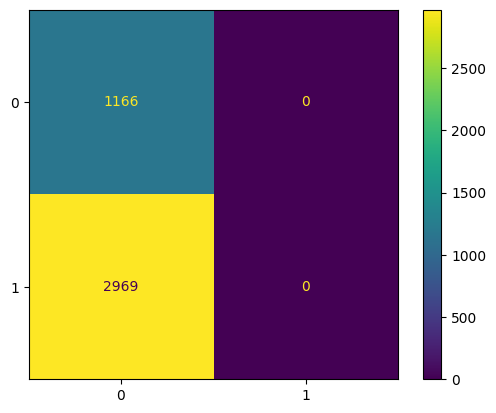

In [129]:
import sklearn
import matplotlib.pyplot as plt
print(sklearn.metrics.confusion_matrix(y_test_nog, predicted_class))
print(sklearn.metrics.classification_report(y_test_nog,predicted_class,target_names=["class0","class1"]))
confusion_matrix = sklearn.metrics.confusion_matrix(y_test_nog,predicted_class)
# dt_score=pipe2.predict_proba(X_test_new)
# print("dt_score is ",dt_score)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2,3])
cm_display.plot()
plt.show()

# LSTM

In [119]:
num_steps=28
num_cols=88
X_train_lstm = X_train_new.reshape(277, num_steps,num_cols)
# X_train_lstm[0].shape
y_train_lstm = y_train_onehot.reshape(277, num_steps, 4)
y_train_lstm.shape

(277, 28, 4)

In [122]:
y_lstm_reshaped = y_train_lstm.reshape(y_train_lstm.shape[0], -1)
y_lstm_reshaped.shape

(277, 112)

In [127]:
tf.config.run_functions_eagerly(True)

In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

ncol = 88
n_units = 100

model2 = Sequential()
model2.add(LSTM(n_units, input_shape=(None, ncol), return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(n_units, return_sequences=True))
model2.add(LSTM(n_units))
model2.add(Dropout(0.5))
model2.add(Dense(50, activation='relu'))
model2.add(Dense(112, activation='softmax'))
model2.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, None, 100)         75600     
                                                                 
 dropout_11 (Dropout)        (None, None, 100)         0         
                                                                 
 lstm_15 (LSTM)              (None, None, 100)         80400     
                                                                 
 lstm_16 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 50)                5050      
                                                                 
 dense_13 (Dense)            (None, 112)              

In [129]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy

model2.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.0001), metrics=[CategoricalAccuracy()])

In [130]:
batch_size2=32
nb_epoch2=100
model2.fit(X_train_lstm, y_lstm_reshaped,
          batch_size=batch_size2,
          epochs=nb_epoch2,
          verbose=1)

Epoch 1/100


C:\Users\rishi\miniconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 2s 205ms/step - loss: 132.1539 - categorical_accuracy: 0.0144
Epoch 2/100
9/9 [==============================] - 2s 201ms/step - loss: 132.1389 - categorical_accuracy: 0.0144
Epoch 3/100
9/9 [==============================] - 2s 200ms/step - loss: 132.1227 - categorical_accuracy: 0.0072
Epoch 4/100
9/9 [==============================] - 2s 200ms/step - loss: 132.1037 - categorical_accuracy: 0.0036
Epoch 5/100
9/9 [==============================] - 2s 200ms/step - loss: 132.1139 - categorical_accuracy: 0.0000e+00
Epoch 6/100
9/9 [==============================] - 2s 201ms/step - loss: 132.3227 - categorical_accuracy: 0.0000e+00
Epoch 7/100
9/9 [==============================] - 2s 202ms/step - loss: 133.2488 - categorical_accuracy: 0.0000e+00
Epoch 8/100
9/9 [==============================] - 2s 200ms/step - loss: 136.6198 - categorical_accuracy: 0.0000e+00
Epoch 9/100
9/9 [==============================] - 2s 200ms/step - loss: 142.1126 - categori

# Decision Tree Without K-fold Cross Validation

In [63]:
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing decision_tree, total=   1.1s
Utterance level accuracy:  0.5417170495767836
Speaker level accuracy:  0.75
[[1 1]
 [0 2]]
              precision    recall  f1-score   support

      class0       0.30      0.38      0.34       669
      class1       0.68      0.62      0.65      1656
      class2       0.19      0.11      0.14       497
      class3       0.61      0.68      0.64      1313

    accuracy                           0.54      4135
   macro avg       0.44      0.45      0.44      4135
weighted avg       0.54      0.54      0.54      4135



ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (2).

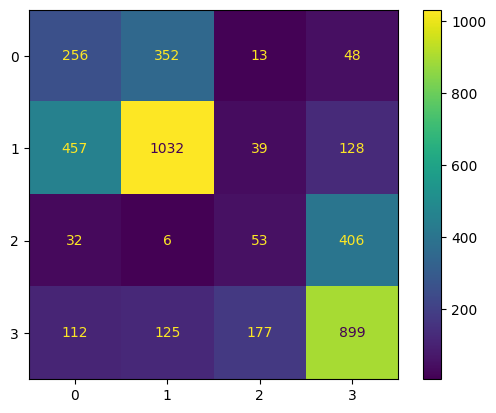

In [64]:
pipe2 = Pipeline([ ('std', StandardScaler()), ('decision_tree', DecisionTreeClassifier())], verbose = True)

# fitting the data in the pipe
pipe2.fit(X_train_new, y_train)

prob_score2=pipe2.predict_proba(X_test_new)
print("Utterance level accuracy: ",accuracy_score(y_test, pipe2.predict(X_test_new)))
accuracy(y_test, prob_score2, s_test)
# print(sklearn.metrics.f1_score(y_test, pipe2.predict(X_test_new)))
print(classification_report(y_test, pipe2.predict(X_test_new),target_names=["class0","class1","class2","class3"]))
confusion_matrix = metrics.confusion_matrix(y_test, pipe2.predict(X_test_new))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

# Performing K-fold cross validation and building the new model

In [38]:
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv):
    _scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)

    return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }



In [39]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

decision_tree_model_2 = DecisionTreeClassifier(criterion="entropy",
                                               min_samples_split=2,
                                               random_state=0)
decision_tree_result_2 = cross_validation(decision_tree_model_2, X_train_new, y_train, 5)
print(decision_tree_result_2)

plot_result(model_name,
            "F1",
            "F1 Scores in 5 Folds",
            decision_tree_result_2["Training F1 scores"],
            decision_tree_result_2["Validation F1 scores"])

plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            decision_tree_result_2["Training Accuracy scores"],
            decision_tree_result_2["Validation Accuracy scores"])


{'Training Accuracy scores': array([1., 1., 1., 1., 1.]), 'Mean Training Accuracy': 100.0, 'Training Precision scores': array([1., 1., 1., 1., 1.]), 'Mean Training Precision': 1.0, 'Training Recall scores': array([1., 1., 1., 1., 1.]), 'Mean Training Recall': 1.0, 'Training F1 scores': array([1., 1., 1., 1., 1.]), 'Mean Training F1 Score': 1.0, 'Validation Accuracy scores': array([0.74236641, 0.76830045, 0.77084659, 0.76830045, 0.74729472]), 'Mean Validation Accuracy': 75.94217229265165, 'Validation Precision scores': array([0.82152007, 0.8440208 , 0.83914894, 0.84689414, 0.83807829]), 'Mean Validation Precision': 0.8379324463525188, 'Validation Recall scores': array([0.83074266, 0.84110535, 0.85220398, 0.8366465 , 0.81417459]), 'Mean Validation Recall': 0.8349746157279487, 'Validation F1 scores': array([0.82610562, 0.84256055, 0.84562607, 0.84173913, 0.82595353]), 'Mean Validation F1 Score': 0.8363969819989382}


NameError: name 'plot_result' is not defined

# Decision Tree after 5-fold Cross Validation


In [89]:
pipe2 = Pipeline([ ('std', StandardScaler()), ('decision_tree', decision_tree_model_2)], verbose = True)

# fitting the data in the pipe
pipe2.fit(X_train_new, y_train)

decision_tree_model_2.predict_proba(X_test_new,y_test)
prob_score2=pipe2.predict_proba(X_test_new)
print("Utterance level accuracy: ",accuracy_score(y_test, pipe2.predict(X_test_new)))
accuracy(y_test, prob_score2, s_test)
print(sklearn.metrics.f1_score(y_test, pipe2.predict(X_test_new)))
print(classification_report(y_test, pipe2.predict(X_test_new),target_names=["class0","class1"]))
confusion_matrix = metrics.confusion_matrix(y_test, pipe2.predict(X_test_new))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

NameError: name 'decision_tree_model_2' is not defined

# Random forest (No Need of K-fold cross validation)


In [91]:
pipe1 = Pipeline([ ('std', StandardScaler()), ('Random_forest', RandomForestClassifier(n_estimators = 150))], verbose = True)

# fitting the data in the pipe
pipe1.fit(X_train_new, y_train)

prob_score=pipe1.predict_proba(X_test_new)
print("Utterance level accuracy: ", accuracy_score(y_test, pipe1.predict(X_test_new)))
accuracy(y_test, prob_score, s_test)
print(sklearn.metrics.f1_score(y_test, pipe1.predict(X_test_new)))
print(classification_report(y_test, pipe2.predict(X_test_new),target_names=["class0","class1","class2","class3"]))
confusion_matrix = metrics.confusion_matrix(y_test, pipe2.predict(X_test_new))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

[Pipeline] ............... (step 1 of 2) Processing std, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Random_forest, total=  10.4s
Utterance level accuracy:  0.6222490931076179
Speaker level accuracy:  0.5
[[1 1]
 [1 1]]


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

### Possible Conclusion for Decision Tree, 5 Fold Validated Decision Tree and Random Forest:
1. After performing 5-fold cross validation on a decision tree model, both utterance and speaker level accuracy
   slightly improved. However, the F1 score in both the decision tree models remain same.
2. Speaker level accuracy is better in case of decision tree after 5-fold cross validation compared to speaker level accuracy in case of Random Forest. However, utterance level accuracy is better in case of Random forest.
3. The F1 score in case of all the three models remain the same.

# Support Vector Machine

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn modules & classes
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn import metrics


In [ ]:
# Instantiate the Support Vector Classifier (SVC)
svc = SVC(C=1.0, random_state=1, kernel='linear',probability=True)

# Fit the model
svc.fit(X_train_new, y_train)

In [ ]:
pipe1 = Pipeline([ ('std', StandardScaler()), ('SVC', SVC(C=1.0, random_state=1, kernel='linear', probability=True))], verbose = True)

# fitting the data in the pipe
pipe1.fit(X_train_new, y_train)

prob_score=pipe1.predict_proba(X_test_new)
print("Utterance level accuracy: ", accuracy_score(y_test, pipe1.predict(X_test_new)))
accuracy(y_test, prob_score, s_test)
print(sklearn.metrics.f1_score(y_test, pipe1.predict(X_test_new)))
print(classification_report(y_test, pipe2.predict(X_test_new),target_names=["class0","class1"]))
confusion_matrix = metrics.confusion_matrix(y_test, pipe2.predict(X_test_new))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

## Logistic Regression

In [ ]:
from sklearn import linear_model

In [ ]:
logr = linear_model.LogisticRegression()
logr.fit(X_train_new,y_train)

In [ ]:
pipe1 = Pipeline([ ('std', StandardScaler()), ('LR', linear_model.LogisticRegression())], verbose = True)

# fitting the data in the pipe
pipe1.fit(X_train_new, y_train)

prob_score=pipe1.predict_proba(X_test_new)
print("Utterance level accuracy: ", accuracy_score(y_test, pipe1.predict(X_test_new)))
accuracy(y_test, prob_score, s_test)
print(sklearn.metrics.f1_score(y_test, pipe1.predict(X_test_new)))
print(classification_report(y_test, pipe2.predict(X_test_new),target_names=["class0","class1"]))
confusion_matrix = metrics.confusion_matrix(y_test, pipe2.predict(X_test_new))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

# Final Conclusion:


1. The five models used in classification of Depressed and Non-Depressed speech provide the following Accuracy:

## Utterance Level Accuracy

a. Decision Tree : 0.5949214026602176,
b. Decision Tree (CV) : 0.626118500604595,
c. Random Forest : 0.6740024183796857,
d. SVM           : 0.7180169286577993,
e. Logistic Regg : 0.7139056831922612

Hence, We can say that SVM is giving the best result.

## Speaker Level Accuracy

a. Decision Tree : 0.7021276595744681, b. Decision Tree (CV) : 0.7659574468085106, c. Random Forest : 0.7021276595744681, d. SVM : 0.7021276595744681, e. Logistic Regg : 0.7446808510638298

Hence , Decision Tree(CV) is performing best at speaker level.

## F1 Score

a. Decision Tree : 0.7943240768996034, b. Decision Tree (CV) : 0.793355684242609, c. Random Forest: 0.7921820125209956, d. SVM : 0.8358671171171171, e. Logistic Regg : 0.8282270945259185

Hence, SVM is  giving the best F1 score.